В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score


In [8]:
df = pd.read_csv('data/bank-customer-churn-prediction-dlu/train.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [12]:
df.drop(columns=['id'], inplace=True)

In [24]:
df['Gender'].value_counts()
#є дві статі


Gender
Male      8529
Female    6471
Name: count, dtype: int64

In [25]:
df['Gender'].value_counts().sum()
#пропущених значень немає

15000

In [27]:
df['Gender'] = np.where(df['Gender']=='Male', 1, 0)

In [29]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15779985.0,Nwankwo,678.0,France,1,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,15650086.0,Ch'in,687.0,France,0,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,15733602.0,Thompson,682.0,France,0,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,15645794.0,Macleod,753.0,Germany,1,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,15633840.0,Hsia,544.0,Germany,0,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [90]:
df.describe()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,658.944133,0.568600,37.739600,5.025267,42729.791988,1.590933,0.788800,0.489667,117784.666193,0.203467
std,72.255926,0.495288,8.218363,2.776678,59727.309419,0.532306,0.408174,0.499910,45734.445888,0.402590
min,431.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,603.000000,0.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,83058.140000,0.000000
50%,662.000000,1.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,123584.870000,0.000000
75%,708.000000,1.000000,42.000000,7.000000,109531.017500,2.000000,1.000000,1.000000,156884.705000,0.000000
max,850.000000,1.000000,74.000000,10.000000,209767.310000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [43]:
df['CustomerId'] = df["CustomerId"].astype("str")

In [30]:
df['Geography'].value_counts()

Geography
France     9032
Spain      3303
Germany    2665
Name: count, dtype: int64

In [32]:
input_cols = df.drop(columns = ['Exited']).columns
input_cols

Index(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary'],
      dtype='object')

In [34]:
target_col = ["Exited"];
target_col[0]

'Exited'

In [120]:
inputs = df[input_cols]
targets = df[target_col]
inputs_train, inputs_val, targets_train, targets_val = train_test_split(inputs, targets, test_size=0.1, random_state=12, stratify=df[target_col])

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [121]:
number_cols = inputs.select_dtypes(include="number").columns.to_list()
print(number_cols)
categorical_cols = inputs.select_dtypes(include="object").columns.to_list()
print(categorical_cols)
categorical_cols.remove('CustomerId')
categorical_cols.remove('Surname')
print(categorical_cols)

['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
['CustomerId', 'Surname', 'Geography']
['Geography']


In [122]:
number_cols_to_scale = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [123]:
scaler = MinMaxScaler()
scaler.fit(inputs_train[number_cols_to_scale])
inputs_train[number_cols_to_scale] = scaler.transform(inputs_train[number_cols_to_scale])
inputs_val[number_cols_to_scale] = scaler.transform(inputs_val[number_cols_to_scale])

In [124]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoder.fit(inputs_train[categorical_cols])
categories_encoded_cols = encoder.get_feature_names_out().tolist()
print(categories_encoded_cols)
inputs_train[categories_encoded_cols] = encoder.transform(inputs_train[categorical_cols])
inputs_val[categories_encoded_cols] = encoder.transform(inputs_val[categorical_cols])

['Geography_France', 'Geography_Germany', 'Geography_Spain']


In [119]:
inputs_val.drop(columns=['CustomerId', 'Surname', 'Geography'], axis=1)

5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [129]:
!pip install pyarrow --quiet

In [131]:
inputs_train.to_parquet("data/bank-customer-churn-prediction-dlu/inputs_train.parquet")
inputs_val.to_parquet("data/bank-customer-churn-prediction-dlu/inputs_val.parquet")
targets_train.to_parquet("data/bank-customer-churn-prediction-dlu/targets_train.parquet")
targets_val.to_parquet("data/bank-customer-churn-prediction-dlu/targets_val.parquet")

6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [125]:
X_train = inputs_train.drop(columns=['CustomerId', 'Surname', 'Geography'], axis=1)
X_val = inputs_val.drop(columns=['CustomerId', 'Surname', 'Geography'], axis=1)

In [126]:
X_train

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
12112,0.756563,1,0.232143,7.0,0.000000,1.0,1.0,0.0,0.503590,1.0,0.0,0.0
3025,0.467780,1,0.410714,7.0,0.000000,2.0,1.0,1.0,0.304835,1.0,0.0,0.0
13655,0.696897,0,0.285714,1.0,0.650687,1.0,1.0,0.0,0.502775,0.0,0.0,1.0
13705,0.603819,1,0.285714,8.0,0.000000,2.0,1.0,0.0,0.875244,1.0,0.0,0.0
14086,0.346062,1,0.303571,3.0,0.578070,1.0,0.0,0.0,0.076973,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
13280,0.384248,0,0.464286,4.0,0.256345,1.0,1.0,1.0,0.357573,1.0,0.0,0.0
13483,0.482100,1,0.321429,6.0,0.000000,2.0,1.0,0.0,0.593693,1.0,0.0,0.0
284,0.508353,0,0.375000,6.0,0.000000,2.0,1.0,0.0,0.805393,1.0,0.0,0.0
1774,0.866348,0,0.285714,1.0,0.681280,1.0,1.0,1.0,0.832363,1.0,0.0,0.0


In [151]:
model = LogisticRegression()
model.fit(X_train, targets_train['Exited'])
predY = model.predict(X_train)
ypred_proba = model.predict_proba(X_train)

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [152]:
confusion_matrix(targets_train['Exited'], predY, normalize='true')

array([[0.95917418, 0.04082582],
       [0.4630506 , 0.5369494 ]])

In [153]:
f1_score(targets_train['Exited'], predY)

0.6329113924050634

63% - досить непоганий результат на тренувальних даних

In [155]:
ypred_proba

array([[0.90664261, 0.09335739],
       [0.96315019, 0.03684981],
       [0.84517375, 0.15482625],
       ...,
       [0.79249507, 0.20750493],
       [0.9528217 , 0.0471783 ],
       [0.98172863, 0.01827137]])

In [158]:
fpr,tpr, tresholds = roc_curve(targets_train['Exited'], predY)
print(fpr)
print(tpr)

[0.         0.04082582 1.        ]
[0.        0.5369494 1.       ]


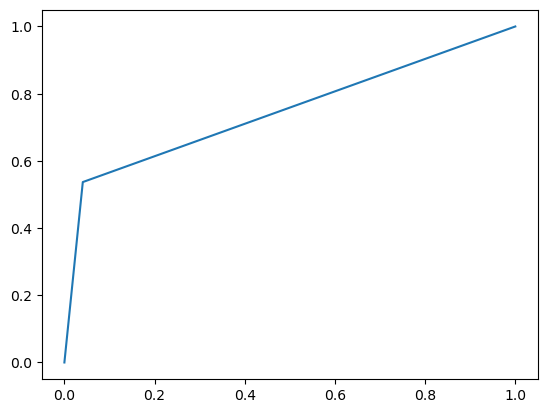

In [164]:
plt.plot(fpr, tpr)

In [166]:
ypred_proba

array([[0.90664261, 0.09335739],
       [0.96315019, 0.03684981],
       [0.84517375, 0.15482625],
       ...,
       [0.79249507, 0.20750493],
       [0.9528217 , 0.0471783 ],
       [0.98172863, 0.01827137]])

In [167]:
roc_auc_score(targets_train['Exited'], predY)

0.7480617916467026

In [168]:
predY_val = model.predict(X_val)

In [172]:
confusion_matrix(targets_val['Exited'], predY_val, normalize="true")

array([[0.95983264, 0.04016736],
       [0.43606557, 0.56393443]])

In [173]:
f1_score(targets_val["Exited"], predY_val)

0.6552380952380952

In [194]:
predY_val_proba = model.predict_proba(X_val)

In [195]:
predY_val_proba

array([[0.99541418, 0.00458582],
       [0.9180068 , 0.0819932 ],
       [0.96714839, 0.03285161],
       ...,
       [0.98492723, 0.01507277],
       [0.56790686, 0.43209314],
       [0.81563568, 0.18436432]])

In [196]:
predY_val_proba = predY_val_proba[:, 0]

In [188]:
fpr_val, tpr_val, tresholds_val = roc_curve(targets_val["Exited"], predY_val)

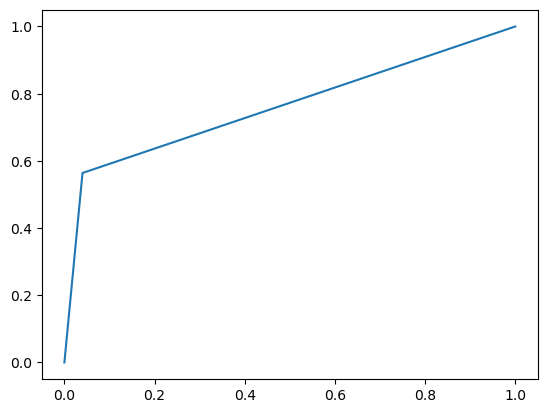

In [189]:
plt.plot(fpr_val, tpr_val)

In [190]:
roc_auc_score(targets_val['Exited'], predY_val)

0.761883531106386

На валідаційних даних модель показує себе дуже добре

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [204]:
predY_negative_train = [0]*13500
confusion_matrix(targets_train, predY_negative_train)

array([[10753,     0],
       [ 2747,     0]])

In [211]:
accuracy_train_negative = (10753/13500)
accuracy_train_negative

0.7965185185185185

In [205]:
predY_negative_val = [0]*1500
confusion_matrix(targets_val, predY_negative_val)

array([[1195,    0],
       [ 305,    0]])

In [208]:
accuracy_val_negative = 1195/1500
accuracy_val_negative

0.7966666666666666

In [214]:
train_confusion_matrix = confusion_matrix(targets_train['Exited'], predY)
print("Train confusion matrix")
print(train_confusion_matrix)
val_confusion_matrix = confusion_matrix(targets_val['Exited'], predY_val)
print("Val confusion matrix")
print(val_confusion_matrix)

Train confusion matrix
[[10314   439]
 [ 1272  1475]]
Val confusion matrix
[[1147   48]
 [ 133  172]]


In [217]:
train_confusion_matrix.sum()

13500

In [218]:
(train_confusion_matrix[0, 0]+train_confusion_matrix[1, 1])/train_confusion_matrix.sum()

0.8732592592592593

In [219]:
(val_confusion_matrix[0, 0]+val_confusion_matrix[1, 1])/val_confusion_matrix.sum()

0.8793333333333333

Показник accuracy для моделі, яка завжди повертає 0 - 71 і 79 відсотків,
в той час як натренована модель повертає кращі результати - 87 і 88 відсотків

На мою думку модель досить непогана)

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [222]:
bank_data = {'model': model, 'scaler': scaler, 'encoder': encoder}
joblib.dump(bank_data, "data/models/log_reg.joblib")

['data/models/log_reg.joblib']

In [223]:
bank_data2 = joblib.load("data/models/log_reg.joblib")

In [224]:
model_2 = bank_data2.get('model')

In [227]:
model_2

LogisticRegression()

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [241]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame, number_cols_to_scale):
    input_df[number_cols_to_scale] = scaler.transform(input_df[number_cols_to_scale])
    encoded_cols = encoder.get_feature_names_out().tolist()
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    input_df['Gender'] = np.where(input_df['Gender']=='Male', 1, 0)
    X_input = input_df[numeric_cols + encoded_cols]
    prob = model.predict_proba(X_input)[:,1]
    return prob

In [230]:
predict_raw_df(scaler, encoder, number_cols, categorical_cols, df[:5], number_cols_to_scale)

array([0.00669406, 0.03263617, 0.34536148, 0.38399149, 0.97437875])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [267]:
test_raw_df = pd.read_csv('data/bank-customer-churn-prediction-dlu/test.csv')

In [268]:
test_raw_df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24995,15642997.0,Chukwumaobim,639.0,Spain,Male,38.0,10.0,0.00,2.0,1.0,1.0,49637.65
9996,24996,15739271.0,Clements,678.0,Spain,Male,39.0,9.0,0.00,2.0,1.0,1.0,142513.50
9997,24997,15756743.0,Chidiebere,774.0,France,Male,30.0,9.0,0.00,2.0,1.0,0.0,4861.72
9998,24998,15680167.0,Yermakova,595.0,France,Male,38.0,6.0,144875.79,1.0,1.0,0.0,126469.09


In [269]:
pred = predict_raw_df(scaler, encoder, number_cols, categorical_cols, test_raw_df, number_cols_to_scale)

In [270]:
test_raw_df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,15000,15594796.0,Chu,0.365155,Germany,1,0.214286,2.0,0.696265,1.0,1.0,1.0,0.789477,0.0,1.0,0.0
1,15001,15642821.0,Mazzi,0.286396,France,1,0.375000,5.0,0.000000,2.0,1.0,1.0,0.337131,1.0,0.0,0.0
2,15002,15716284.0,Onyekachi,0.656325,France,1,0.446429,8.0,0.000000,2.0,1.0,0.0,0.783859,1.0,0.0,0.0
3,15003,15785078.0,Martin,0.682578,Spain,1,0.482143,3.0,0.000000,1.0,1.0,1.0,0.834571,0.0,0.0,1.0
4,15004,15662955.0,Kenechukwu,0.384248,Spain,1,0.446429,8.0,0.000000,2.0,1.0,1.0,0.718421,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24995,15642997.0,Chukwumaobim,0.496420,Spain,1,0.357143,10.0,0.000000,2.0,1.0,1.0,0.248154,0.0,0.0,1.0
9996,24996,15739271.0,Clements,0.589499,Spain,1,0.375000,9.0,0.000000,2.0,1.0,1.0,0.712578,0.0,0.0,1.0
9997,24997,15756743.0,Chidiebere,0.818616,France,1,0.214286,9.0,0.000000,2.0,1.0,0.0,0.024253,1.0,0.0,0.0
9998,24998,15680167.0,Yermakova,0.391408,France,1,0.357143,6.0,0.690650,1.0,1.0,0.0,0.632348,1.0,0.0,0.0


In [275]:
test_raw_df['Exited']=pred

In [271]:
test_raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,15000,15594796.0,Chu,0.365155,Germany,1,0.214286,2.0,0.696265,1.0,1.0,1.0,0.789477,0.0,1.0,0.0
1,15001,15642821.0,Mazzi,0.286396,France,1,0.375000,5.0,0.000000,2.0,1.0,1.0,0.337131,1.0,0.0,0.0
2,15002,15716284.0,Onyekachi,0.656325,France,1,0.446429,8.0,0.000000,2.0,1.0,0.0,0.783859,1.0,0.0,0.0
3,15003,15785078.0,Martin,0.682578,Spain,1,0.482143,3.0,0.000000,1.0,1.0,1.0,0.834571,0.0,0.0,1.0
4,15004,15662955.0,Kenechukwu,0.384248,Spain,1,0.446429,8.0,0.000000,2.0,1.0,1.0,0.718421,0.0,0.0,1.0


In [272]:
test_raw_df.set_index('id', inplace=True)

In [273]:
test_raw_df

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
id,,,,,,,,,,,,,,,
15000,15594796.0,Chu,0.365155,Germany,1,0.214286,2.0,0.696265,1.0,1.0,1.0,0.789477,0.0,1.0,0.0
15001,15642821.0,Mazzi,0.286396,France,1,0.375000,5.0,0.000000,2.0,1.0,1.0,0.337131,1.0,0.0,0.0
15002,15716284.0,Onyekachi,0.656325,France,1,0.446429,8.0,0.000000,2.0,1.0,0.0,0.783859,1.0,0.0,0.0
15003,15785078.0,Martin,0.682578,Spain,1,0.482143,3.0,0.000000,1.0,1.0,1.0,0.834571,0.0,0.0,1.0
15004,15662955.0,Kenechukwu,0.384248,Spain,1,0.446429,8.0,0.000000,2.0,1.0,1.0,0.718421,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,15642997.0,Chukwumaobim,0.496420,Spain,1,0.357143,10.0,0.000000,2.0,1.0,1.0,0.248154,0.0,0.0,1.0
24996,15739271.0,Clements,0.589499,Spain,1,0.375000,9.0,0.000000,2.0,1.0,1.0,0.712578,0.0,0.0,1.0
24997,15756743.0,Chidiebere,0.818616,France,1,0.214286,9.0,0.000000,2.0,1.0,0.0,0.024253,1.0,0.0,0.0


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [246]:
submissions = pd.read_csv("data/bank-customer-churn-prediction-dlu/sample_submission.csv")

In [255]:
submissions.reset_index(drop="True")
submissions.set_index('id', inplace=True)

In [257]:
submissions

,Exited
id,
15000,0.5
15001,0.5
15002,0.5
15003,0.5
15004,0.5
...,...
24995,0.5
24996,0.5
24997,0.5


In [264]:
list(submissions.index)

[15000,
 15001,
 15002,
 15003,
 15004,
 15005,
 15006,
 15007,
 15008,
 15009,
 15010,
 15011,
 15012,
 15013,
 15014,
 15015,
 15016,
 15017,
 15018,
 15019,
 15020,
 15021,
 15022,
 15023,
 15024,
 15025,
 15026,
 15027,
 15028,
 15029,
 15030,
 15031,
 15032,
 15033,
 15034,
 15035,
 15036,
 15037,
 15038,
 15039,
 15040,
 15041,
 15042,
 15043,
 15044,
 15045,
 15046,
 15047,
 15048,
 15049,
 15050,
 15051,
 15052,
 15053,
 15054,
 15055,
 15056,
 15057,
 15058,
 15059,
 15060,
 15061,
 15062,
 15063,
 15064,
 15065,
 15066,
 15067,
 15068,
 15069,
 15070,
 15071,
 15072,
 15073,
 15074,
 15075,
 15076,
 15077,
 15078,
 15079,
 15080,
 15081,
 15082,
 15083,
 15084,
 15085,
 15086,
 15087,
 15088,
 15089,
 15090,
 15091,
 15092,
 15093,
 15094,
 15095,
 15096,
 15097,
 15098,
 15099,
 15100,
 15101,
 15102,
 15103,
 15104,
 15105,
 15106,
 15107,
 15108,
 15109,
 15110,
 15111,
 15112,
 15113,
 15114,
 15115,
 15116,
 15117,
 15118,
 15119,
 15120,
 15121,
 15122,
 15123,
 15124,


In [281]:
for k in list(submissions.index):
    submissions.loc[k]['Exited'] = test_raw_df.loc[k]['Exited'].round(2)

In [282]:
submissions.sort_values('Exited', ascending=False)

,Exited
id,
17182,1.00
17371,0.99
20173,0.99
19737,0.99
22619,0.99
...,...
23926,0.00
18129,0.00
17544,0.00


In [283]:
submissions.head()

,Exited
id,
15000,0.08
15001,0.03
15002,0.16
15003,0.20
15004,0.06


In [284]:
submissions.to_csv("data/bank-customer-churn-prediction-dlu/submission_log_reg.csv")